## BƯỚC 1: CHUẨN BỊ DỮ LIỆU

In [1]:
# tải thư viện
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk.corpus import stopwords
import re
import pickle
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import os 

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tgdd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tgdd\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
# Load Spacy model for NER
nlp = spacy.load("en_core_web_sm")

In [4]:
# tải datasets
cv_df = pd.read_csv('D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/datasets/General_Data_CV.csv')
jd_df = pd.read_csv('D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/datasets/General_Data_JD.csv')

In [5]:
# Hiển thị 5 dòng dầu cv_df
cv_df.head()

,Category,Resume
0,DATABASE ADMINISTRATOR,Office Staff Database Administrator Office Sta...
1,WEB DEVELOPER,Reactjs developer Reactjs span ldeveloperspan ...
2,SOFTWARE DEVELOPER,Jim Ryan Software Developer jimm_ryyn89@gmail....
3,PYTHON DEVELOPER,VPN Project Consultant Silgan Containers VPN P...
4,PYTHON DEVELOPER,Principal clientserver ops analyst Principal c...


In [6]:
# Hiển thị 5 dòng đầu jd_df
jd_df.head()

,Job Title,Job Description
0,GRADUATE JAVA SOFTWARE DEVELOPER IT SOFTWARE ...,"graduate java software developer – web, agile,..."
1,ANDROID APPLICATION DEVELOPER MOBILE SOLUTION...,android application developer west london req...
2,SOFTWARE DEVELOPMENT ENGINEER,"Do you enjoy watching the latest movies, telev..."
3,FULL STACK DEVELOPER,transcriptic robotic cloud laboratory life sci...
4,SCRUM MASTER,About the job We would be happy to consider yo...


In [7]:
# lấy danh sách các cột (tên cột) của cv_df
cv_df.columns

Index(['Category', 'Resume'], dtype='object')

In [8]:
# lấy danh sách các cột (tên cột) của jd_df
jd_df.columns

Index(['Job Title', 'Job Description'], dtype='object')

In [9]:
print('Độ dài của cv_df là: ', len(cv_df))

Độ dài của cv_df là:  19551


In [10]:
print('Độ dài của cv_df là: ', len(jd_df))

Độ dài của cv_df là:  19551


In [11]:
# hiển thị số hàng và cột của cv_df
cv_df.shape

(19551, 2)

In [12]:
# hiển thị số hàng và cột của jd_df
jd_df. shape

(19551, 2)

In [13]:
# hiển thị thông tin tổng quan cv_df
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19551 entries, 0 to 19550
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  19551 non-null  object
 1   Resume    19549 non-null  object
dtypes: object(2)
memory usage: 305.6+ KB


In [14]:
# hiển thị thông tin tổng quan jd_cv
jd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19551 entries, 0 to 19550
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Title        19551 non-null  object
 1   Job Description  19551 non-null  object
dtypes: object(2)
memory usage: 305.6+ KB


In [15]:
# hiển thị kiểu dữ liệu (data type) của từng cột trong cv_df
cv_df.dtypes

Category    object
Resume      object
dtype: object

In [16]:
# hiển thị kiểu dữ liệu (data type) của từng cột trong jd_df
jd_df.dtypes

Job Title          object
Job Description    object
dtype: object

In [17]:
# Kiểm tra giá trị thiếu trong cột Resume của cv_df
print(f"Số giá trị thiếu trong Resume: {cv_df['Resume'].isna().sum()}")

Số giá trị thiếu trong Resume: 2


In [18]:
# Kiểm tra giá trị thiếu trong cột desc của jd_cv
print(f"Số giá trị thiếu trong desc: {jd_df['Job Description'].isna().sum()}")

Số giá trị thiếu trong desc: 0


In [19]:
# Kiểm tra giá trị thiếu trong cột Category của cv_df
print(f"Số giá trị thiếu trong Category: {cv_df['Category'].isna().sum()}")

Số giá trị thiếu trong Category: 0


In [20]:
# Kiểm tra giá trị thiếu trong cột title của jd_cv
print(f"Số giá trị thiếu trong title: {jd_df['Job Title'].isna().sum()}")

Số giá trị thiếu trong title: 0


In [21]:
# Xóa các dòng có giá trị thiếu trong Resume_str
cv_df = cv_df.dropna(subset=['Resume']).reset_index(drop=True)

# In số dòng sau khi xóa giá trị thiếu
print(f"Số dòng sau khi xóa giá trị thiếu: {len(cv_df )}")

Số dòng sau khi xóa giá trị thiếu: 19549


In [22]:
# chọn ngẫu nhiên 19549 JD để ghép với 19549 CV
jd_sample = jd_df.sample(n=len(cv_df), random_state=42).reset_index(drop=True)
cv_df = cv_df.reset_index(drop=True)

In [30]:
# Kết hợp làm sạch văn bản và trích xuất tính năng NER
stop_words = set(stopwords.words('english'))
def preprocess_and_extract_features(text):
    """
    Xử lý văn bản và trích xuất thông tin kỹ năng, kinh nghiệm, học vấn cho ngành CNTT
    Tự động điều chỉnh phạm vi quét theo độ dài văn bản
    """
    # Tiền xử lý cơ bản
    text = text.lower()
    text = re.sub(r'\S+@\S+', ' ', text)  # Remove emails
    text = re.sub(r'http\S+|www\S+', ' ', text)  # Remove URLs
    text = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)  # Remove phone numbers
    text = ''.join([char for char in text if char.isalnum() or char.isspace() or char in [',', '.', '-']])
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Chuẩn hóa thuật ngữ CNTT
    replacements = {
        r'\b(yrs?|years?)\b': 'years',
        r'\b(exp|experience)\b': 'experience',
        r'\b(edu|education)\b': 'education',
        r'\b(prog|programming)\b': 'programming',
        r'\b(dev|developer)\b': 'developer',
        r'\b(eng|engineer)\b': 'engineer',
        r'\b(c#|csharp)\b': 'c#',
        r'\b(js|javascript)\b': 'javascript',
        r'\b(py|python)\b': 'python'
    }
    for pattern, repl in replacements.items():
        text = re.sub(pattern, repl, text)
    
    # Từ điển keyword cho ngành CNTT
    it_skill_keywords = [
    # Các phần header thông thường
    'skills', 'technical skills', 'technical competencies', 'key skills',
    'core competencies', 'technical expertise', 'skill set', 'skill summary',
    'programming skills', 'technical abilities', 'professional skills',
    
    # Các cách diễn đạt về kỹ năng
    'proficient in', 'experienced in', 'knowledge of', 'expertise in',
    'skilled in', 'familiar with', 'competent in', 'adept at', 
    'strong background in', 'hands-on experience with', 'working knowledge of',
    
    # Các loại kỹ năng cụ thể
    'programming languages', 'frameworks', 'tools', 'libraries',
    'platforms', 'databases', 'cloud technologies', 'devops tools',
    'frontend technologies', 'backend technologies', 'fullstack technologies',
    'mobile development', 'ai/ml technologies', 'data science tools',
    'cybersecurity skills', 'networking knowledge', 'operating systems',
    'version control systems', 'ci/cd tools', 'containerization',
    'testing frameworks', 'debugging tools', 'ide experience',
    
    # Các kỹ năng mềm liên quan
    'problem solving', 'algorithm design', 'system architecture',
    'code optimization', 'performance tuning', 'security practices',
    'agile methodologies', 'code review', 'technical documentation'
]

    it_experience_keywords = [
    # Các phần header thông thường
    'experience', 'work experience', 'professional experience',
    'employment history', 'career history', 'work background',
    'professional background', 'relevant experience',
    
    # Các cách diễn đạt về kinh nghiệm
    'worked as', 'served as', 'held position as', 'acted as',
    'years of experience', 'hands-on experience', 'it experience',
    'technical experience', 'industry experience', 'practical experience',
    
    # Các hoạt động công việc
    'projects', 'implemented', 'developed', 'deployed', 'architected',
    'engineered', 'designed', 'built', 'created', 'maintained',
    'optimized', 'debugged', 'tested', 'documented', 'led',
    'managed', 'coordinated', 'collaborated on', 'contributed to',
    
    # Các mức độ kinh nghiệm
    'junior', 'senior', 'lead', 'principal', 'architect', 'manager',
    'director', 'team lead', 'technical lead', 'subject matter expert',
    
    # Các loại kinh nghiệm cụ thể
    'full-time', 'part-time', 'contract', 'freelance', 'internship',
    'volunteer'
]

    it_education_keywords = [
    # Các phần header thông thường
    'education', 'academic background', 'qualifications',
    'degrees', 'certifications', 'academic credentials',
    'educational background', 'training', 'courses',
    
    # Các loại tổ chức giáo dục
    'university', 'college', 'institute', 'school', 'academy',
    'polytechnic', 'technical school', 'bootcamp', 'online course',
    
    # Các bằng cấp
    'bachelor', "bachelor's", 'bsc', 'bs', 'b.eng', 'b.tech',
    'master', "master's", 'msc', 'ms', 'm.eng', 'm.tech',
    'phd', 'ph.d', 'doctorate', 'postdoc', 'postdoctoral',
    'diploma', 'certificate', 'associate degree',
    
    # Các chuyên ngành CNTT
    'computer science', 'information technology', 'software engineering',
    'data science', 'computer engineering', 'it', 'cybersecurity',
    'network engineering', 'artificial intelligence', 'machine learning',
    'computer systems', 'database systems', 'web development',
    'mobile development', 'cloud computing', 'devops',
    
    # Các khóa học và đào tạo
    'coursework', 'relevant courses', 'training programs',
    'professional development', 'certification programs',
    'online learning', 'moocs', 'workshops', 'seminars'
]
    
    # Tự động điều chỉnh phạm vi quét
    text_length = len(text)
    base_range = min(1000, max(300, int(text_length * 0.3)))  # Từ 300-1000 ký tự
    
    scan_ranges = {
        'skills': base_range * 1.5,  # Ưu tiên quét rộng hơn cho kỹ năng
        'experience': base_range,
        'education': base_range
    }
    
    # Hàm quét thông minh
    def smart_scan(content, keyword, scan_range):
        pos = content.find(keyword)
        if pos == -1:
            return ""
    
        start = max(0, pos - 50)  # Quét ngược 50 ký tự
        end = min(len(content), start + int(scan_range))  # Ensure scan_range is integer
    
        # Ưu tiên lấy đến hết section nếu có dấu phân cách
        next_section = re.search(r'\n\s*\n', content[int(pos):int(end)])  # Convert to integers
        if next_section:
            end = pos + next_section.start()
    
        return content[int(start):int(end)].strip()  # Ensure integer indices
    
    # Trích xuất thông tin
    skills = set()
    experience = set()
    education = set()
    
    # 1. Trích xuất kỹ năng CNTT
    for keyword in it_skill_keywords:
        section = smart_scan(text, keyword, scan_ranges['skills'])
        if section:
            # Trích xuất từ danh sách
            skill_items = re.split(r'[,•\-–;()\n/]', section)
            for item in skill_items:
                item = item.strip()
                if 2 <= len(item) <= 50:  # Độ dài hợp lý
                    skills.add(item.title())
            
            # Trích xuất bằng NER
            doc = nlp(section)
            for ent in doc.ents:
                if ent.label_ in ['ORG', 'PRODUCT'] and any(char.isalpha() for char in ent.text):
                    skills.add(ent.text.title())
    
    # 2. Trích xuất kinh nghiệm
    for keyword in it_experience_keywords:
        section = smart_scan(text, keyword, scan_ranges['experience'])
        if section:
            # Số năm kinh nghiệm
            years_exp = re.findall(
                r'(\d+)\s*(?:\+)?\s*(?:years?|yrs?)(?:\s*(?:of|in)\s*(?:experience|exp))?', 
                section
            )
            for year in years_exp:
                experience.add(f"{year} years experience")
            
            # Vị trí công việc
            job_titles = re.findall(
                r'(?:senior|junior|lead|principal)?\s*'
                r'(?:software|it|data|devops|cloud|systems)?\s*'
                r'(?:engineer|developer|architect|analyst|specialist)', 
                section
            )
            for title in job_titles:
                experience.add(title.title())
    
    # 3. Trích xuất học vấn
    for keyword in it_education_keywords:
        section = smart_scan(text, keyword, scan_ranges['education'])
        if section:
            # Bằng cấp
            degrees = re.findall(
                r'(bsc|b\.?sc|bachelor|bs|b\.?s|'
                r'msc|m\.?sc|master|ms|m\.?s|'
                r'phd|ph\.?d|doctorate)\b', 
                section, flags=re.IGNORECASE
            )
            for degree in degrees:
                education.add(degree.title())
            
            # Tên trường
            doc = nlp(section)
            for ent in doc.ents:
                if ent.label_ == 'ORG' and any(w in ent.text.lower() for w in ['university', 'college', 'institute']):
                    education.add(ent.text.title())
    
    # Làm sạch kết quả
    def clean_items(items):
        cleaned = set()
        for item in items:
            item = re.sub(r'[^\w\s\-\.#+]', '', item)  # Loại bỏ ký tự đặc biệt
            item = item.strip()
            if item and not item.isdigit():
                cleaned.add(item)
        return sorted(cleaned)
    
    return {
        'cleaned_text': ' '.join([token.lemma_ for token in nlp(text) if token.text not in stop_words]),
        'features': {
            'skills': clean_items(skills),
            'experience': clean_items(experience),
            'education': clean_items(education)
        }
    }

In [31]:
# Áp dụng tiền xử lý và trích xuất tính năng cho CV và JD
cv_results = [preprocess_and_extract_features(text) for text in cv_df['Resume']]
jd_results = [preprocess_and_extract_features(text) for text in jd_sample['Job Description']]

In [32]:
# Trích xuất các văn bản và tính năng đã được làm sạch
cv_texts = [result['cleaned_text'] for result in cv_results]
jd_texts = [result['cleaned_text'] for result in jd_results]
cv_features = [result['features'] for result in cv_results]
jd_features = [result['features'] for result in jd_results]

In [33]:
# Chuẩn hóa các thuật ngữ phổ biến
def normalize_terms(text):
    # Chuyển đổi văn bản thành chữ thường để khớp không phân biệt chữ hoa chữ thường
    text_lower = text.lower()
    
    # Từ điển thay thế mở rộng
    replacements = {
        # Ngôn ngữ lập trình
        'javascript': 'js',
        'java script': 'js',
        'python': 'py',
        'c plus plus': 'c++',
        'cplus plus': 'c++',
        'c plusplus': 'c++',
        'c#': 'csharp',
        'c sharp': 'csharp',
        'java': 'java',
        'ruby': 'ruby',
        'php': 'php',
        'go': 'go',
        'golang': 'go',
        'rust': 'rust',
        'kotlin': 'kotlin',
        'swift': 'swift',
        'typescript': 'ts',
        'scala': 'scala',
        'perl': 'perl',
        'r language': 'r',
        'r programming': 'r',
        'dart': 'dart',
        'lua': 'lua',
        'elixir': 'elixir',
        'erlang': 'erlang',
        'haskell': 'haskell',
        'clojure': 'clojure',
        'f#': 'fsharp',
        'f sharp': 'fsharp',
        'groovy': 'groovy',
        'matlab': 'matlab',
        'shell scripting': 'shell',
        'bash': 'bash',
        'powershell': 'powershell',
        
        # Khung và Thư viện
        'scikit-learn': 'sklearn',
        'scikit learn': 'sklearn',
        'tensorflow': 'tensorflow',
        'tensor flow': 'tensorflow',
        'pytorch': 'pytorch',
        'pandas': 'pandas',
        'numpy': 'numpy',
        'django': 'django',
        'flask': 'flask',
        'fastapi': 'fastapi',
        'spring': 'spring',
        'spring boot': 'springboot',
        'hibernate': 'hibernate',
        'asp.net': 'aspnet',
        'asp net': 'aspnet',
        'vb.net': 'vbnet',
        'vb net': 'vbnet',
        'j2ee': 'j2ee',
        'node.js': 'nodejs',
        'node js': 'nodejs',
        'react': 'react',
        'reactjs': 'react',
        'react.js': 'react',
        'angular': 'angular',
        'angularjs': 'angular',
        'vue.js': 'vuejs',
        'vuejs': 'vuejs',
        'vue js': 'vuejs',
        'express': 'express',
        'express.js': 'express',
        'laravel': 'laravel',
        'symfony': 'symfony',
        'rails': 'rails',
        'ruby on rails': 'rails',
        'next.js': 'nextjs',
        'nextjs': 'nextjs',
        'nuxt.js': 'nuxtjs',
        'nuxtjs': 'nuxtjs',
        'svelte': 'svelte',
        'sveltekit': 'sveltekit',
        'meteor': 'meteor',
        'backbone.js': 'backbonejs',
        'ember.js': 'emberjs',
        'jquery': 'jquery',
        'bootstrap': 'bootstrap',
        'tailwind css': 'tailwind',
        'material ui': 'mui',
        'ant design': 'antd',
        
        # Công cụ và Môi trường phát triển
        'visual studio': 'vs',
        'visual studio code': 'vscode',
        'vs code': 'vscode',
        'intellij': 'intellij',
        'intellij idea': 'intellij',
        'eclipse': 'eclipse',
        'pycharm': 'pycharm',
        'webstorm': 'webstorm',
        'rubymine': 'rubymine',
        'android studio': 'androidstudio',
        'xcode': 'xcode',
        'jupyter': 'jupyter',
        'jupyter notebook': 'jupyter',
        'jupyter lab': 'jupyterlab',
        'git': 'git',
        'github': 'github',
        'gitlab': 'gitlab',
        'bitbucket': 'bitbucket',
        'svn': 'svn',
        'mercurial': 'mercurial',
        'npm': 'npm',
        'yarn': 'yarn',
        'pnpm': 'pnpm',
        'maven': 'maven',
        'gradle': 'gradle',
        'ant': 'ant',
        'cmake': 'cmake',
        'make': 'make',
        
        # Databases
        'mysql': 'mysql',
        'sql server': 'sqlserver',
        'microsoft sql server': 'sqlserver',
        'ms sql server': 'sqlserver',
        'postgresql': 'postgres',
        'postgres': 'postgres',
        'oracle': 'oracle',
        'mongodb': 'mongodb',
        'redis': 'redis',
        'cassandra': 'cassandra',
        'dynamodb': 'dynamodb',
        'sqlite': 'sqlite',
        'mariadb': 'mariadb',
        'couchdb': 'couchdb',
        'neo4j': 'neo4j',
        'influxdb': 'influxdb',
        'rethinkdb': 'rethinkdb',
        'nosql': 'nosql',
        'elasticsearch': 'elasticsearch',
        'elastic search': 'elasticsearch',
        'opensearch': 'opensearch',
        
        # Artificial Intelligence and Machine Learning
        'machine learning': 'ml',
        'deep learning': 'dl',
        'natural language processing': 'nlp',
        'computer vision': 'cv',
        'support vector machine': 'svm',
        'k nearest neighbors': 'knn',
        'k-nearest neighbors': 'knn',
        'principal component analysis': 'pca',
        'random forest': 'rf',
        'decision tree': 'dt',
        'naive bayes': 'nb',
        'naïve bayes': 'nb',
        'gradient boosting': 'gb',
        'xgboost': 'xgboost',
        'lightgbm': 'lightgbm',
        'catboost': 'catboost',
        'yolo': 'yolo',
        'convolutional neural network': 'cnn',
        'recurrent neural network': 'rnn',
        'long short term memory': 'lstm',
        'gated recurrent unit': 'gru',
        'transformer': 'transformer',
        'bert': 'bert',
        'gpt': 'gpt',
        't5': 't5',
        'roberta': 'roberta',
        'llama': 'llama',
        'mistral': 'mistral',
        'generative ai': 'genai',
        'reinforcement learning': 'rl',
        'federated learning': 'fl',
        'autoencoders': 'autoencoders',
        'gan': 'gan',
        'generative adversarial network': 'gan',
        
        # DevOps và CI/CD
        'devops': 'devops',
        'continuous integration': 'ci',
        'continuous deployment': 'cd',
        'continuous delivery': 'cd',
        'docker': 'docker',
        'kubernetes': 'k8s',
        'k8s': 'k8s',
        'helm': 'helm',
        'jenkins': 'jenkins',
        'ansible': 'ansible',
        'terraform': 'terraform',
        'puppet': 'puppet',
        'chef': 'chef',
        'gitlab ci': 'gitlabci',
        'github actions': 'ghactions',
        'circleci': 'circleci',
        'travis ci': 'travisci',
        'bamboo': 'bamboo',
        'prometheus': 'prometheus',
        'grafana': 'grafana',
        'elk stack': 'elk',
        'splunk': 'splunk',
        'new relic': 'newrelic',
        'datadog': 'datadog',
        
        # Điện toán đám mây
        'cloud computing': 'cloud',
        'amazon web services': 'aws',
        'aws': 'aws',
        'microsoft azure': 'azure',
        'azure': 'azure',
        'google cloud platform': 'gcp',
        'gcp': 'google cloud',
        'google cloud': 'google cloud',
        'ibm cloud': 'ibmcloud',
        'oracle cloud': 'oraclecloud',
        'alibaba cloud': 'alibabacloud',
        'heroku': 'heroku',
        'digitalocean': 'digitalocean',
        'linode': 'linode',
        'vultr': 'vultr',
        'serverless': 'serverless',
        'aws lambda': 'awslambda',
        'azure functions': 'azurefunctions',
        'google cloud functions': 'gcpfunctions',
        'cloudformation': 'cloudformation',
        'azure resource manager': 'arm',
        
        # An ninh mạng
        'cybersecurity': 'cybersecurity',
        'information security': 'infosec',
        'infosec': 'infosec',
        'owasp': 'owasp',
        'oauth': 'oauth',
        'openid': 'openid',
        'saml': 'saml',
        'ssl': 'ssl',
        'tls': 'tls',
        'penetration testing': 'pentest',
        'pentest': 'pentest',
        'ethical hacking': 'ethicalhacking',
        'vulnerability assessment': 'vulnassess',
        'siem': 'siem',
        'firewall': 'firewall',
        'ids': 'ids',
        'ips': 'ips',
        'vpn': 'vpn',
        'zero trust': 'zerotrust',
        
        # Phương pháp phát triển
        'agile': 'agile',
        'scrum': 'scrum',
        'kanban': 'kanban',
        'lean': 'lean',
        'test driven development': 'tdd',
        'tdd': 'tdd',
        'behavior driven development': 'bdd',
        'bdd': 'bdd',
        'pair programming': 'pairprogramming',
        'extreme programming': 'xp',
        'xp': 'xp',
        'devsecops': 'devsecops',
        'site reliability engineering': 'sre',
        'sre': 'sre',
        
        # UI/UX
        'user interface': 'ui',
        'ui': 'ui',
        'user experience': 'ux',
        'ux': 'ux',
        'front end': 'frontend',
        'frontend': 'frontend',
        'back end': 'backend',
        'backend': 'backend',
        'full stack': 'fullstack',
        'fullstack': 'fullstack',
        'responsive design': 'responsivedesign',
        'progressive web app': 'pwa',
        'pwa': 'pwa',
        
        # API và Tích hợp
        'application programming interface': 'api',
        'api': 'api',
        'rest': 'rest',
        'restful': 'rest',
        'graphql': 'graphql',
        'soap': 'soap',
        'grpc': 'grpc',
        'microservices': 'microservices',
        'service oriented architecture': 'soa',
        'soa': 'soa',
        'event driven architecture': 'eda',
        'eda': 'eda',
        
        # Data Analysis and Visualization
        'tableau': 'tableau',
        'power bi': 'powerbi',
        'powerbi': 'powerbi',
        'qlikview': 'qlikview',
        'qliksense': 'qliksense',
        'looker': 'looker',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
        'plotly': 'plotly',
        'ggplot': 'ggplot',
        'd3.js': 'd3js',
        'd3js': 'd3js',
        
        # Big Data
        'hadoop': 'hadoop',
        'hadoop ecosystem': 'hadoop',
        'spark': 'spark',
        'apache spark': 'spark',
        'kafka': 'kafka',
        'apache kafka': 'kafka',
        'flink': 'flink',
        'hive': 'hive',
        'pig': 'pig',
        'hbase': 'hbase',
        'impala': 'impala',
        'sqoop': 'sqoop',
        'oozie': 'oozie',
        'zookeeper': 'zookeeper',
        'airflow': 'airflow',
        'nifi': 'nifi',
        
        # Education
        'bachelor of science': 'bs',
        'b.s.': 'bs',
        'bsc': 'bs',
        'bs': 'bs',
        'bachelor of arts': 'ba',
        'b.a.': 'ba',
        'ba': 'ba',
        'master of science': 'ms',
        'm.s.': 'ms',
        'msc': 'ms',
        'ms': 'ms',
        'master of arts': 'ma',
        'm.a.': 'ma',
        'ma': 'ma',
        'bachelor of technology': 'btech',
        'b.tech': 'btech',
        'btech': 'btech',
        'ph.d.': 'phd',
        'phd': 'phd',
        'doctor of philosophy': 'phd',
        'm.b.a.': 'mba',
        'mba': 'mba',
        'master of business administration': 'mba',
        'bachelor of engineering': 'beng',
        'b.eng': 'beng',
        'beng': 'beng',
        'bachelor of computer science': 'bcs',
        'bcs': 'bcs',
        
        # Chứng chỉ CNTT
        'aws certified': 'awscertified',
        'aws solutions architect': 'awscertified',
        'aws developer': 'awscertified',
        'aws sysops': 'awscertified',
        'microsoft certified': 'mscertified',
        'azure certified': 'azurecertified',
        'google cloud certified': 'gcpcertified',
        'cisco certified network associate': 'ccna',
        'ccna': 'ccna',
        'cisco certified network professional': 'ccnp',
        'ccnp': 'ccnp',
        'certified information systems security professional': 'cissp',
        'cissp': 'cissp',
        'certified ethical hacker': 'ceh',
        'ceh': 'ceh',
        'comptia security+': 'securityplus',
        'security+': 'securityplus',
        'comptia network+': 'networkplus',
        'network+': 'networkplus',
        'comptia a+': 'aplus',
        'a+': 'aplus',
        'scrum master': 'scrummaster',
        'certified scrum master': 'scrummaster',
        'pmp': 'pmp',
        'project management professional': 'pmp',
        'itil': 'itil',
        'togaf': 'togaf',
        'six sigma': 'sixsigma',
        
        # Experience
        'one year': '1 year',
        'two years': '2 years',
        'three years': '3 years',
        'four years': '4 years',
        'five years': '5 years',
        'six years': '6 years',
        'seven years': '7 years',
        'eight years': '8 years',
        'nine years': '9 years',
        'ten years': '10 years',
        
        # Thuật ngữ CNTT khác
        'data science': 'ds',
        'software engineer': 'swe',
        'software engineering': 'swe',
        'data engineer': 'dataengineer',
        'data engineering': 'dataengineer',
        'cloud engineer': 'cloudengineer',
        'ml engineer': 'mlengineer',
        'ai engineer': 'aiengineer',
        'object oriented': 'oo',
        'object-oriented': 'oo',
        'functional programming': 'fp',
        'blockchain': 'blockchain',
        'web3': 'web3',
        'internet of things': 'iot',
        'iot': 'iot',
        'virtual reality': 'vr',
        'vr': 'vr',
        'augmented reality': 'ar',
        'ar': 'ar',
        'mixed reality': 'mr',
        'mr': 'mr',
        'mobile development': 'mobiledev',
        'android development': 'androiddev',
        'ios development': 'iosdev',
        'cross platform': 'crossplatform',
        'flutter': 'flutter',
        'react native': 'reactnative',
        'xamarin': 'xamarin',
        'game development': 'gamedev',
        'unity': 'unity',
        'unreal engine': 'unreal',
        'embedded systems': 'embedded',
        'firmware': 'firmware',
        'robotics': 'robotics',
        'quantum computing': 'quantum',
        'edge computing': 'edgecomputing',
        'data warehouse': 'datawarehouse',
        'etl': 'etl',
        'data lake': 'datalake',
        'data pipeline': 'datapipeline',
        'business intelligence': 'bi',
        'bi': 'bi'
    }
    
    # Thay thế các thuật ngữ bằng cách sử dụng văn bản viết thường, nhưng vẫn giữ nguyên văn bản gốc đối với các phần không khớp
    for key, value in replacements.items():
        # Sử dụng regex để thay thế toàn bộ từ, không phân biệt chữ hoa chữ thường
        import re
        pattern = r'\b' + re.escape(key) + r'\b'
        text = re.sub(pattern, value, text_lower, flags=re.IGNORECASE)
    
    return text

In [34]:
# Áp dụng chuẩn hóa cho các văn bản đã được làm sạch
cv_texts = [normalize_terms(text) for text in cv_texts]
jd_texts = [normalize_terms(text) for text in jd_texts]

In [35]:
# Load Sentence Transformer model
model_st = SentenceTransformer('all-mpnet-base-v2')

In [36]:
# Xác định đường dẫn tệp để embedding
cv_embedding_path = 'D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/embeddings/cv_embeddings.npy'
jd_embedding_path = 'D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/embeddings/jd_embeddings.npy'

In [37]:
# Tải hoặc tạo embedding
if os.path.exists(cv_embedding_path) and os.path.exists(jd_embedding_path):
    print("Đang tải các embedding hiện có...")
    cv_embeddings = np.load(cv_embedding_path)
    jd_embeddings = np.load(jd_embedding_path)
else:
    print("Đang tạo embedding mới...")
    cv_embeddings = model_st.encode(cv_texts, show_progress_bar=True, batch_size=32)
    jd_embeddings = model_st.encode(jd_texts, show_progress_bar=True, batch_size=32)
    # Tạo thư mục embedding nếu nó không tồn tại
    os.makedirs(os.path.dirname(cv_embedding_path), exist_ok=True)
    # Lưu embeddings đến thư mục
    np.save(cv_embedding_path, cv_embeddings)
    np.save(jd_embedding_path, jd_embeddings)
    print(f"Embedding được lưu vào {cv_embedding_path} và {jd_embedding_path}")

Đang tạo embedding mới...


Batches:   0%|          | 0/611 [00:00<?, ?it/s]

Batches:   0%|          | 0/611 [00:00<?, ?it/s]

Embedding được lưu vào D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/embeddings/cv_embeddings.npy và D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/embeddings/jd_embeddings.npy


In [38]:
# Tính toán cosine similarity giữa embeddings
similarities = cosine_similarity(cv_embeddings, jd_embeddings).diagonal()
avg_scores = similarities * 100  # Scale to 0-100

In [39]:
# Kết hợp các tính năng NER vào một định dạng có cấu trúc
def combine_ner_features(cv_feats, jd_feats): 
    # Đếm số lượng khớp giữa các kỹ năng CV và JD
    skill_matches = len(set(cv_feats['skills']) & set(jd_feats['skills']))
    # Đếm các kết quả trùng khớp trong giáo dục (ví dụ: cùng trường đại học hoặc loại bằng cấp)
    education_matches = len(set(cv_feats['education']) & set(jd_feats['education']))
    # Trích xuất nhiều năm kinh nghiệm và so sánh
    cv_exp_years = 0
    jd_exp_years = 0
    for exp in cv_feats['experience']:
        match = re.search(r'(\d+)\s*years?', exp, re.IGNORECASE)
        if match:
            cv_exp_years = max(cv_exp_years, int(match.group(1)))
    for exp in jd_feats['experience']:
        match = re.search(r'(\d+)\s*years?', exp, re.IGNORECASE)
        if match:
            jd_exp_years = max(jd_exp_years, int(match.group(1)))
    exp_match = 1 if cv_exp_years >= jd_exp_years and jd_exp_years > 0 else 0
    return [skill_matches, education_matches, exp_match]

In [40]:
# Tạo mảng tính năng từ NER
ner_features = np.array([combine_ner_features(cv_f, jd_f) for cv_f, jd_f in zip(cv_features, jd_features)])

In [41]:
# Kết hợp embedding và các tính năng NER
X = np.hstack([cv_embeddings, jd_embeddings, ner_features, similarities.reshape(-1, 1)])
y = avg_scores

In [42]:
print(X)

[[ 0.03700898  0.02423519 -0.02078905 ...  1.          0.
   0.24888179]
 [ 0.05830662  0.03760226 -0.05008275 ...  1.          0.
   0.36744112]
 [ 0.05616248  0.00994758 -0.04728708 ...  0.          0.
   0.49052203]
 ...
 [ 0.02262202 -0.01403661 -0.01646734 ...  0.          0.
   0.36812222]
 [ 0.05842919  0.09442427 -0.04634298 ...  0.          1.
   0.45424211]
 [ 0.05108277  0.01832039 -0.03202097 ...  1.          0.
   0.4431861 ]]


In [43]:
print(y)

[24.888178 36.74411  49.052204 ... 36.81222  45.42421  44.31861 ]


In [44]:
# Create labeled dataset
labeled_data = pd.DataFrame({
    'CV_text': cv_texts,
    'JD_text': jd_texts,
    'avg_score': avg_scores
})

In [45]:
# Display the first few rows
print(labeled_data.head())

                                             CV_text  \
0  office staff database administrator office sta...   
1  reactjs developer reactjs span ldeveloperspan ...   
2  jim ryan software developer 917 202 - 5269 new...   
3  vpn project consultant silgan container vpn pr...   
4  principal clientserver op analyst principal cl...   

                                             JD_text  avg_score  
0  aw metering bill generation combine interestin...  24.888178  
1  job 4 - 10 year experience full stack developm...  36.744110  
2  web developer html , css , javascript commutab...  49.052204  
3  job title software development director locati...  39.674042  
4  job key skill requirement experience install ,...  42.988987  


In [46]:
# Save to CSV
labeled_data.to_csv('D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/datasets/labeled_dataset.csv', index=False, encoding="UTF-8")
print('Đã lưu thành công vào labeled_dataset.csv')

Đã lưu thành công vào labeled_dataset.csv


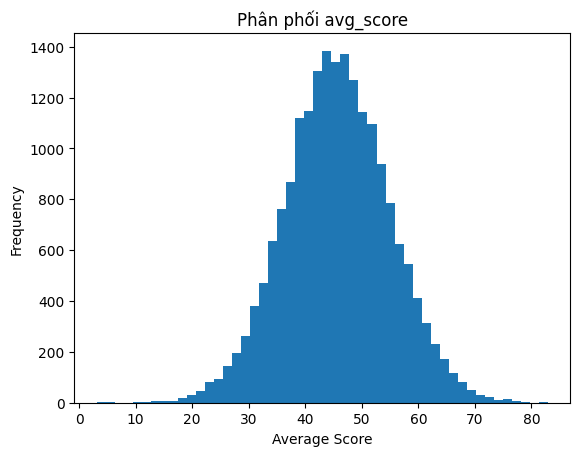

count    19549.000000
mean        45.652675
std          9.228412
min          3.152892
25%         39.493910
50%         45.595776
75%         51.796688
max         82.910520
Name: avg_score, dtype: float64


In [47]:
import matplotlib.pyplot as plt

df = pd.read_csv('D:/BaiDoAnChuyenNganh3/NLPResumeRankingAutomatedSystem/datasets/labeled_dataset.csv')
plt.hist(df['avg_score'], bins=50)
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.title('Phân phối avg_score')
plt.show()
print(df['avg_score'].describe())